In [0]:

# Author: Daniel Azevedo

# This code was adapted from the http://lazyprogrammer.me, who provided the code 
# in the context of the course https://www.udemy.com/data-science-natural-language-processing-in-python


import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re
import requests
import os
import textwrap

from random import random, sample, shuffle, randint
from operator import itemgetter

The goal of this notebook is to **Decrypt a Substitution Cipher**, based on a Language Model represented by a **Bi-gram**. The algorithm used for decription will be a **Evolutionay Algorithm**

## Create Substitution Cipher

In [0]:
### Create Substitution Cipher

def create_cipher():
  
  letters_1 = list(string.ascii_lowercase)
  letters_2 = list(string.ascii_lowercase)

  true_cypher = {}

  # shuffle
  shuffle(letters_2)

  # create mapping between the letters
  for i, j in zip(letters_1, letters_2):
    true_cypher[j] = j

  return true_cypher


## Create the Language Model class

The Language Model learns the probability of a specific sequence of letters, using a Bi-gram and Markov Assumption

In [0]:
### Create the Language Model class: N-Gram using Markov Assumption

class LanguageModel:
  def __init__(self, ngram, pi):
    self.ngram = ngram
    self.pi = pi


  #Compute the ngram probabilities
  def train(self, text_name):

    # for replacing non-alpha characters
    regex = re.compile('[^a-zA-Z]')

    # load in words
    for line in open(text_name):
      line = line.rstrip()

      # exclude blank lines
      if line:
        # replace all non-alpha characters with space
        line = regex.sub(' ', line) 

        # split the tokens in the line and lowercase
        words = line.lower().split()


        for word in words:
          
          # first letter
          ch0 = word[0]
          self.update_pi(ch0)

          # other letters
          for ch1 in word[1:]:
            self.update_probabilities(ch0, ch1)
            ch0 = ch1

    # normalize the probabilities
    self.pi /= self.pi.sum()
    self.ngram /= self.ngram.sum(axis=1, keepdims=True)


  # Compute Initial probabilities
  def update_pi(self, ch):
    i = ord(ch) - 97
    self.pi[i] += 1


  def update_probabilities(self, ch1, ch2):
    # ord('a') = 97
    
    i = ord(ch1) - 97
    j = ord(ch2) - 97
    
    self.ngram[i,j] += 1


  # Compute the log-probability of a word
  def compute_word_prob(self, word):

    i = ord(word[0]) - 97
    logp = np.log(self.pi[i])

    for ch in word[1:]:
      j = ord(ch) - 97
      logp += np.log(self.ngram[i, j])
      i = j

    return logp


  # Compute the probability of a sequence of words
  def compute_sequence_prob(self, words):
    
    #split string into words
    if type(words) == str:
      words = words.split()

    logp = 0
    for word in words:
      logp += self.compute_word_prob(word)
    return logp



In [0]:
### create a markov model based on an English dataset
# is an edit of https://www.gutenberg.org/ebooks/2701
# (I removed the front and back matter)


def get_text_file():
  # Get the test for training the model
  if not os.path.exists('moby_dick.txt'):
    print("Downloading moby dick...")
    r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
    with open('moby_dick.txt', 'w') as f:
      f.write(r.content.decode())

  

In [0]:
### encode a message

# this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''


# Function to Encode and Decode a specific message

In [0]:
# Function to encode a message
def encode_message(msg, cipher):

  msg = msg.lower()

  # replace non-alpha characters
  msg = regex.sub(' ', msg)

  # make the encoded message
  coded_msg = []
  for ch in msg:
    
    #default
    coded_ch = ch
    if ch in cipher:
      coded_ch = cipher[ch]
    coded_msg.append(coded_ch)

  return ''.join(coded_msg)


# Function to decode a message
def decode_message(msg, cipher):
  decoded_msg = []
  for ch in msg:

    #default
    decoded_ch = ch
    if ch in cipher:
      decoded_ch = cipher[ch]
    decoded_msg.append(decoded_ch)

  return ''.join(decoded_msg)



# Create the Evolutionary Algorithm

The goal is to discover the substitution cipher using an Evolutionary Algorithm

In [0]:

class EvolutionaryAlgorithm:
  def __init__(self, n_pop, prob_mutation, prob_crossover, elitism_size, lm):
    
    self.n_pop = n_pop
    self.prob_mutation = prob_mutation
    self.prob_crossover = prob_crossover
    self.elitism_size = elitism_size
    self.best_map = None
    self.model = lm


  def init_population(self, n):

    population = []
    for _ in range(n):
      indv = list(string.ascii_lowercase)
      shuffle(indv)
      population.append(indv)

    return population
  

  #One point Crossover
  def crossover(self, indv_1, indv_2):
    
    if random() < self.prob_crossover:
        
        pos = randint(0,len(indv_1))
        f1 = indv_1[0:pos] + indv_2[pos:]
        f2 = indv_2[0:pos] + indv_1[pos:]
        return [f1, f2]
        
    else:
      return [indv_1,indv_2]


  def swap_mutation(self, indv):
    new_indv = indv.copy()

    if  random() < self.prob_mutation:
      i = np.random.randint(len(new_indv))
      j = np.random.randint(len(new_indv))

      new_indv[i], new_indv[j] = new_indv[j], new_indv[i]

    return new_indv
    

  def elitism(self, population, offspring):
    
    comp_elite = int(len(population) * self.elitism_size)
    
    offspring.sort()
    population.sort()
    
    new_population = population[:comp_elite] + offspring[:len(population) - comp_elite]
    
    return new_population


  def evaluate_population(self, population, original_letters):

    scores = {}
    for indv in population:

      current_map = {}
      for k, v in zip(original_letters, indv):
        current_map[k] = v

      decoded_message = decode_message(encoded_message, current_map)
      score = self.model.compute_sequence_prob(decoded_message)

      scores[''.join(indv)] = [score, current_map]
      
    return scores


  def evolve(self):

    num_iters = 700

    scores = np.zeros(num_iters)
    best_indv = None
    best_score = float('-inf')

    population = self.init_population(self.n_pop)

    for it in range(num_iters):
      

      pool = population
      
      #Crossover
      parents = []
      for i in  range(0, self.n_pop - 1, 2):
          indiv_1= pool[i]
          indiv_2 = pool[i+1]
          parents.extend(self.crossover(indiv_1, indiv_2)) 
      

      #Mutation
      offspring = []
      for indv in parents:
        offspring.append(self.swap_mutation(indv))


      #Select the best inviduals: Elitism
      population = self.elitism(population, offspring)

      pop_scores = self.evaluate_population(population, list(string.ascii_lowercase))

      for s in pop_scores:

        if pop_scores[s][0] > best_score:
          best_indv = s
          self.best_map = pop_scores[s][1]
          best_score = pop_scores[s][0]

      scores[it] = np.mean([pop_scores[s][0] for s in pop_scores])

      if it % 100 == 0:
        print("Iteration ", it, ": score:", round(scores[it], 3), "best so far:", round(best_score, 3))
    
    plt.figure(figsize=(12, 8))
    plt.plot(scores)
    plt.xlabel('Iterations')
    plt.ylabel('Score')
    plt.title('Score Evolution')
    plt.show()



Iteration  0 : score: -2007.98 best so far: -1574.531
Iteration  100 : score: -1674.046 best so far: -1298.377
Iteration  200 : score: -1276.117 best so far: -1061.997
Iteration  300 : score: -1153.363 best so far: -931.343
Iteration  400 : score: -1110.056 best so far: -929.59
Iteration  500 : score: -1122.056 best so far: -929.59
Iteration  600 : score: -1086.039 best so far: -929.59


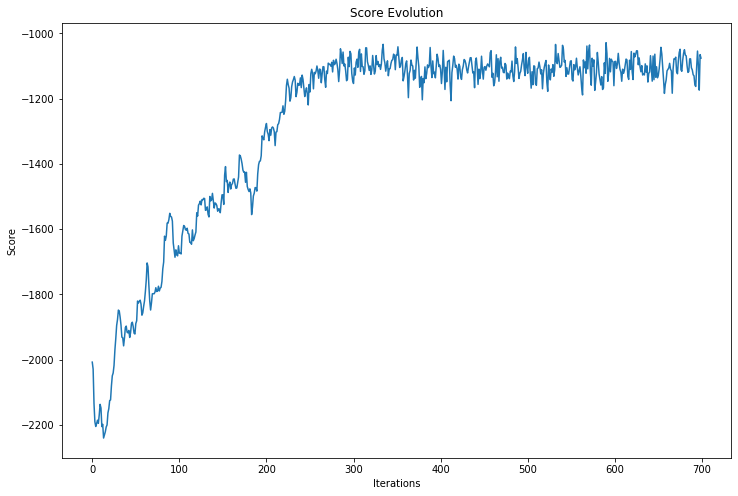




Score of the Decoded Message vs the True Message:
 LL of decoded message: -929.59
 LL of true message: -933.031


Wrong letter in the predicted cipher:
 True: k, Predicted: z
 True: z, Predicted: k


In [247]:
#Initialize the language model

get_text_file()
n_letters = len(list(string.ascii_lowercase))
regex = re.compile('[^a-zA-Z]')

#Create and Train the Language Model
l_model = LanguageModel(np.ones((n_letters, n_letters)), 
                        np.zeros(n_letters))

l_model.train('moby_dick.txt')

#Create True cipher
true_cipher = create_cipher()

#Encode the message according to the created cipher
encoded_message = encode_message(original_message, true_cipher)


# Create the EvolutionaryAlgorithm instance
ea = EvolutionaryAlgorithm(n_pop = 30,
                           prob_mutation = 1,
                           prob_crossover = 0,
                           elitism_size = 0.5,
                           lm = l_model)

# Evolve the algorithm in order to identify the cipher
ea.evolve()


# Decode message accoring to the predicted cipher
decoded_message = decode_message(encoded_message, ea.best_map)

print("\n\n\nScore of the Decoded Message vs the True Message:")
print(" LL of decoded message:", round(l_model.compute_sequence_prob(decoded_message), 3))
print(" LL of true message:", round(l_model.compute_sequence_prob(regex.sub(' ', original_message.lower())), 3))


# Print the wrong letters
print("\n\nWrong letter in the predicted cipher:")
for true, v in true_cipher.items():
  pred = ea.best_map[v]
  if true != pred:
    print(" True: %s, Predicted: %s" % (true, pred))
  

In [248]:
# Print the final decoded message
print("\n\nDecoded message:\n", textwrap.fill(decoded_message))
print("\nTrue message:\n", original_message)



Decoded message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and received in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doken other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I wa

As we can observed, the evolutionary algorithm performed quite well as it only failed two letters in discovering the True cipher. A possible reason for not discovering the whole cipher correctly is the fact that the letters *k* and *z* don't appear too often in the training text, therefore the probabilities with regards to these letters may not be the more accurate